In [ ]:
 #Import dataset and packages
!pip install yfinance
!pip install ta
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
import yfinance as yf

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29089 sha256=0132d37da5111f1f5e78878bcb9d2556b138bb42397908e7ba277993a9c36412
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [ ]:
# ta installation

url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4733    0  4733    0     0   9683      0 --:--:-- --:--:-- --:--:--  9698
100  517k  100  517k    0     0   222k      0  0:00:02  0:00:02 --:--:--  316k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4757    0  4757    0     0   5039      0 --:--:-- --:--:-- --:--:--  5039
100  392k  100  392k    0     0   150k      0  0:00:02  0:00:02 --:--:--  265k


In [ ]:
#Data Collection
stocks = ['0388.HK'] #stock selection (HSBC)
df = yf.download(tickers=stocks, start="2022-08-20", end="2023-08-20", interval="1d") #Date selection
# data_rf = data_rf['Adj Close'] #Data selections: closing price after adjustments
print(df.shape) # Check trading days and information about the stock
print(sum(df['Volume'])) # Find overall order volume
df.head() #Dataset for five risky assets and a risk-free asset


[*********************100%%**********************]  1 of 1 completed
(245, 6)
1183098986


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-22,331.200012,331.799988,328.799988,330.000000,322.885162,3900893
2022-08-23,328.399994,329.600006,324.200012,327.399994,320.341217,3702200
2022-08-24,327.000000,327.399994,318.799988,320.000000,313.100769,4739357
2022-08-25,320.200012,331.799988,319.399994,331.600006,324.450684,3433443
2022-08-26,332.399994,333.200012,325.399994,328.799988,321.711029,3414927


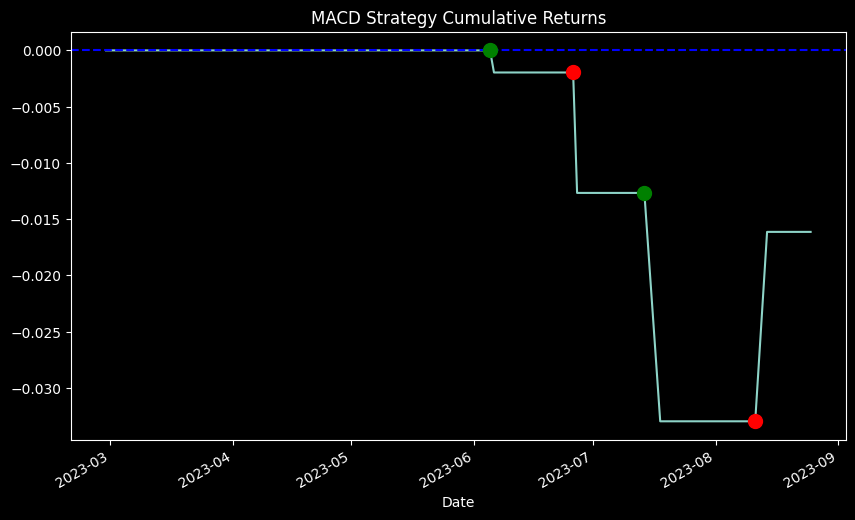

0.017419335149949644
-0.020570609870624312


In [ ]:
import pandas as pd
import talib
plt.style.use("dark_background")

# Load historical price dat

# Calculate MACD and signal line
df["macd"], df["macd_signal"], df["macd_hist"] = talib.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
macd = np.array(df['macd'])
signal = np.array(df['macd_signal'])

# Create a new column for the MACD difference
df['macd_diff'] = macd - signal


# Detect golden cross (when MACD crosses above signal line) and death cross (when MACD crosses below signal line)
df['golden_cross'] = ((df['macd_diff'] > 0) & (df['macd_diff'].shift(1) < 0))
df['death_cross'] = ((df['macd_diff'] < 0) & (df['macd_diff'].shift(1) > 0))

# Generate buy and sell signals based on the MACD crossover
df['signal'] = 0
df.loc[df['golden_cross'] == True, 'signal'] = 1   # Buy signal
df.loc[df['death_cross'] == True, 'signal'] = -1  # Sell signal

# Calculate the returns based on the buy and sell signals
df['returns'] = df['Adj Close'].pct_change() * df['signal'].shift(1)

# Calculate the cumulative returns
cumulative_returns = (1 + df['returns']).cumprod() - 1

# Plot the cumulative returns and golden/death cross markers
ax = cumulative_returns.plot(figsize=(10, 6), title='MACD Strategy Cumulative Returns')
plt.axhline(y=0, color='blue', linestyle='--', label='Overbought')
ax.plot(df.loc[df['golden_cross']].index, cumulative_returns[df['golden_cross']], 'go', markersize=10)
ax.plot(df.loc[df['death_cross']].index, cumulative_returns[df['death_cross']], 'ro', markersize=10)


plt.show()
df[33:]
print(df["returns"].max())
print(df["returns"].min())


Long： 291.3999938964844
Short： 284.6000061035156
Long： 337.6000061035156
Short： 324.20001220703125


Text(0.5, 1.0, "Bollinger's bond outlook['0388.HK']")

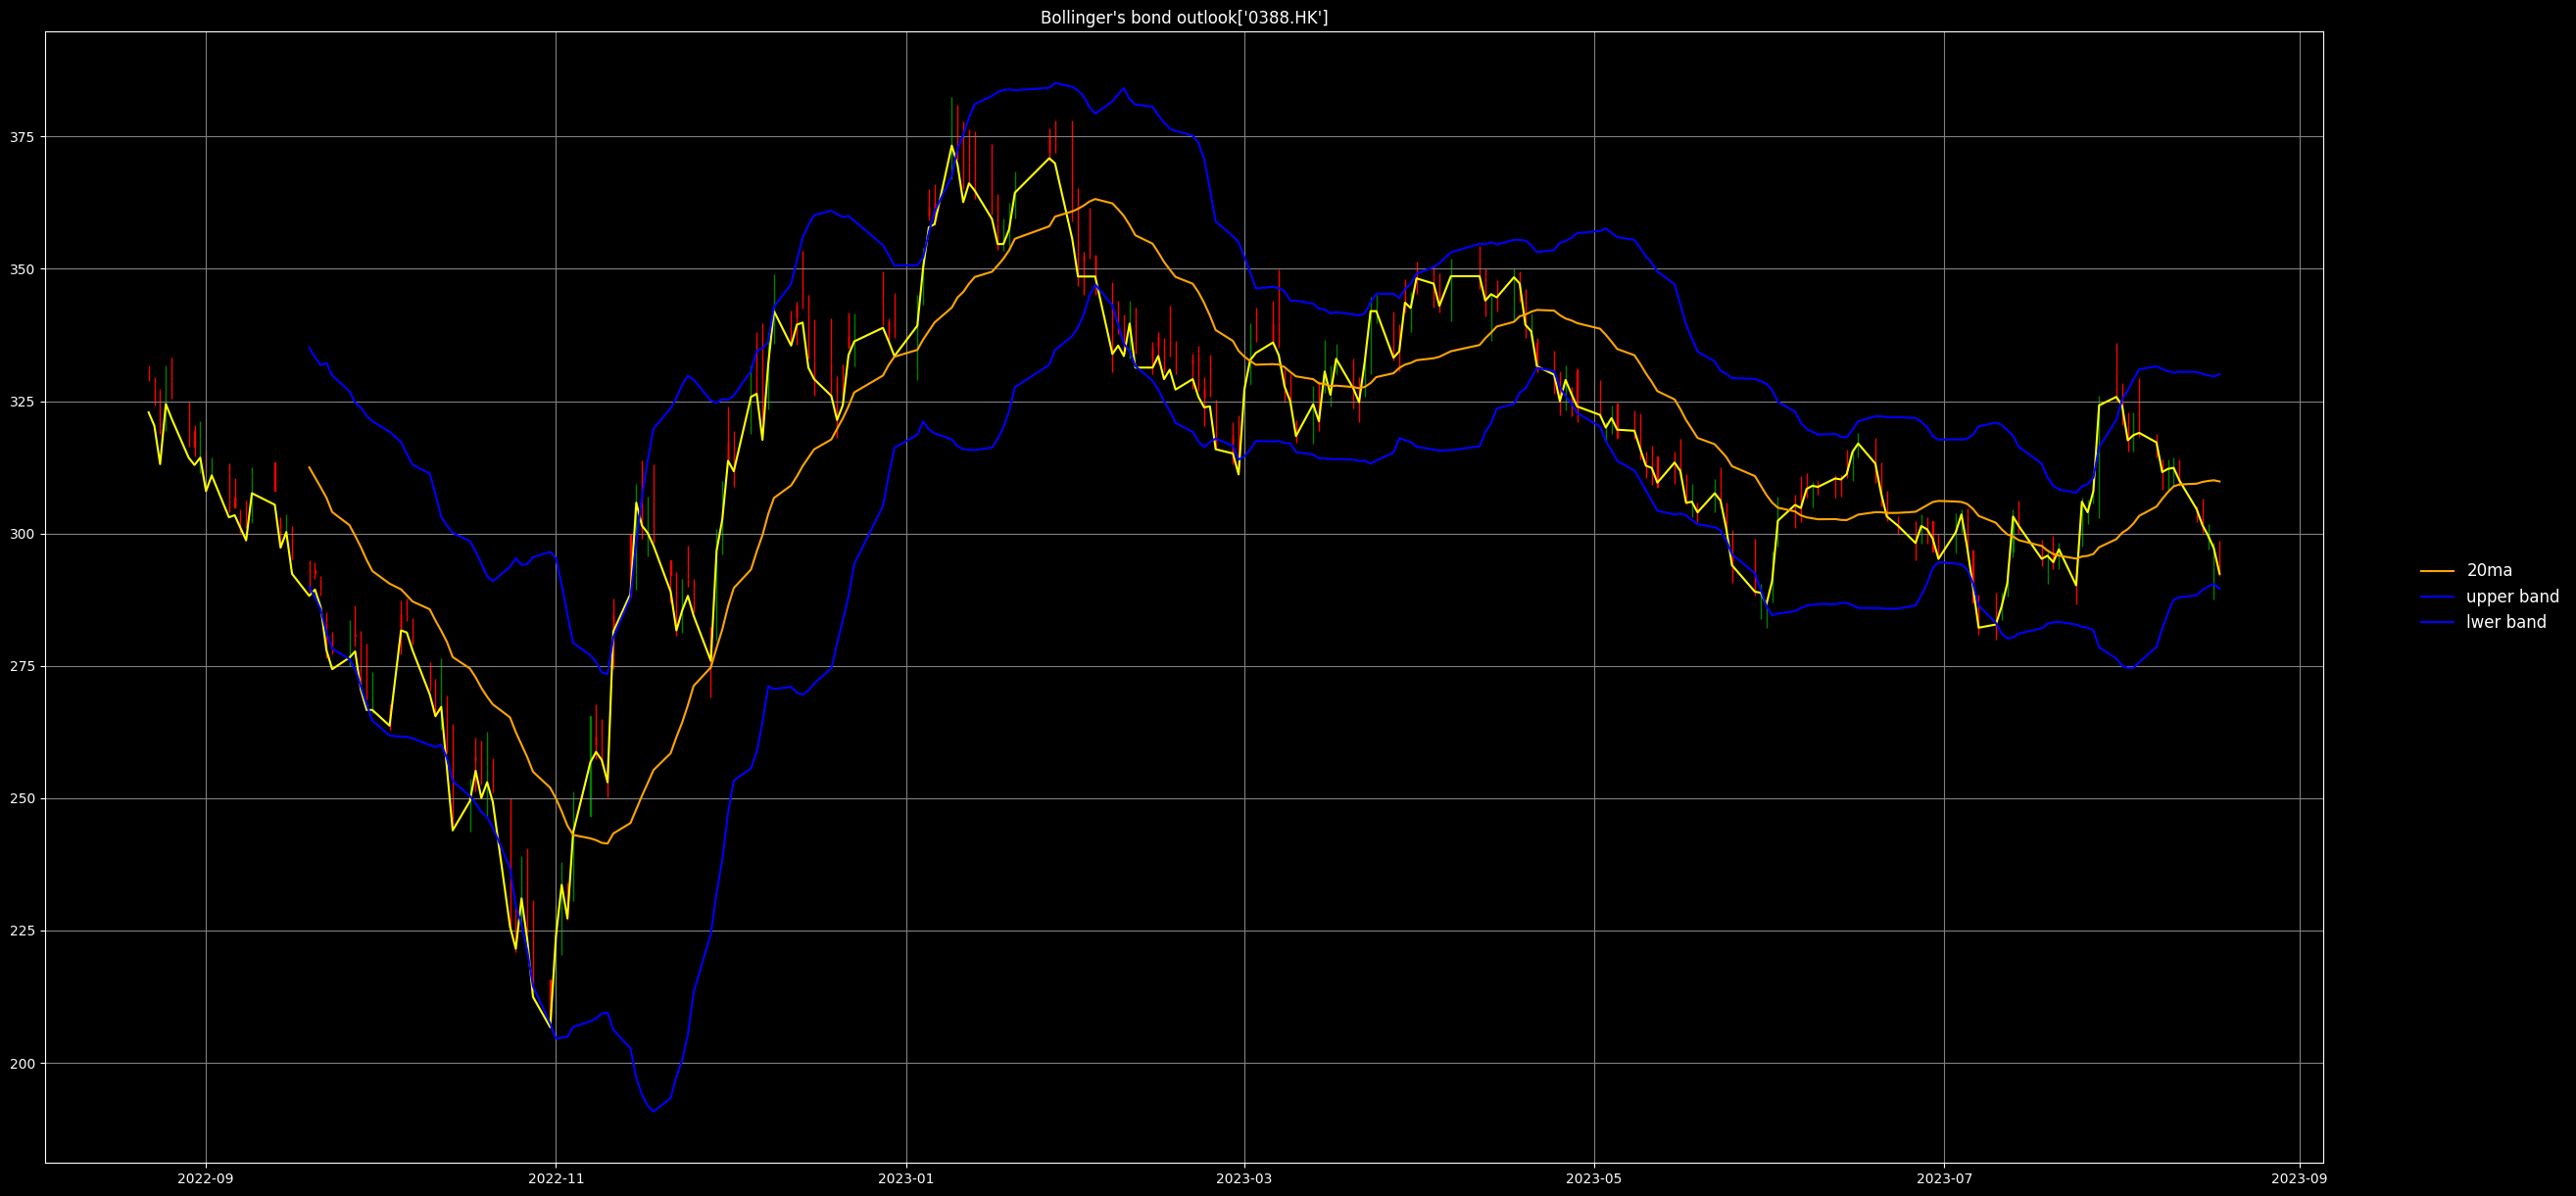

In [ ]:
import ta
import yfinance as yf

# 載入歷史股價資料

# 計算 Bollinger Band
# EMA = 20 with average
df['20ma'] = ta.volatility.bollinger_mavg(df['Close'], window=20)
df['upper'] = ta.volatility.bollinger_hband(df['Close'], window=20)
df['lower'] = ta.volatility.bollinger_lband(df['Close'], window=20)

# 確認交易訊號
df['long'] = df['Adj Close'] < df['lower']
df['short'] = df['Adj Close'] > df['upper']

# 進行交易
position = 0
for i in range(len(df)):
    if df['long'][i]:
        if position == 0:
            position = 1
            print('Long：', df['Close'][i])
    elif df['short'][i]:
        if position == 1:
            position = 0
            print('Short：', df['Close'][i])

width  = 0.015   # width of real body
width2 = 0.005  # width of shadow
fig, ax = plt.subplots(figsize=(30,15))
# find the rows that are bullish
dfup = df[df["Adj Close"] >= df.Open]
# find the rows that are bearish
dfdown = df[df["Adj Close"] < df.Open]
# plot the bullish candle stick
ax.bar(dfup.index, dfup.Close - dfup.Open, width,
       bottom = dfup.Open, edgecolor='g', color='green')
ax.bar(dfup.index, dfup.High - dfup.Close, width2,
       bottom = dfup.Close, edgecolor='g', color='green')
ax.bar(dfup.index, dfup.Low - dfup.Open, width2,
       bottom = dfup.Open, edgecolor='g', color='green')
# plot the bearish candle stick
ax.bar(dfdown.index, dfdown.Close - dfdown.Open, width,
       bottom = dfdown.Open, edgecolor='r', color='red')
ax.bar(dfdown.index, dfdown.High - dfdown.Open, width2,
       bottom = dfdown.Open, edgecolor='r', color='red')
ax.bar(dfdown.index, dfdown.Low - dfdown.Close, width2,
       bottom = dfdown.Close, edgecolor='r', color='red')



ax.plot(df.index, df["Adj Close"], color='yellow')
ax.grid(color='gray')
plt.plot(df.index,df['20ma'],label='20ma',color='orange')
plt.plot(df.index,df['upper'],label='upper band',color='b')
plt.plot(df.index,df['lower'],label='lwer band',color='b')
plt.legend(bbox_to_anchor=(1.04,0.5),loc = "center left",borderaxespad = 0,frameon = False,fontsize=12)
plt.title("Bollinger's bond outlook{}".format(stocks))


Buy signal detected on 2022-09-22 at 277.93.
Order closed on 2022-11-07 at 256.76.
Profit/Loss: -7.62%
Sell signal detected on 2022-11-11 at 281.49.
Profit/Loss: 1.28%
Sell signal detected on 2022-11-14 at 288.61.
Profit/Loss: 3.84%
Sell signal detected on 2022-11-15 at 305.82.
Profit/Loss: 10.04%
Sell signal detected on 2023-01-05 at 357.84.
Profit/Loss: 28.75%
Sell signal detected on 2023-01-09 at 373.27.
Profit/Loss: 34.31%
Buy signal detected on 2023-02-28 at 311.16.
Order closed on 2023-03-02 at 332.72.
Profit/Loss: 6.93%
Buy signal detected on 2023-05-25 at 294.00.
Order closed on 2023-06-07 at 308.40.
Profit/Loss: 4.90%
Sell signal detected on 2023-07-28 at 324.20.
Profit/Loss: 10.27%
Sell signal detected on 2023-07-31 at 325.80.
Profit/Loss: 10.82%


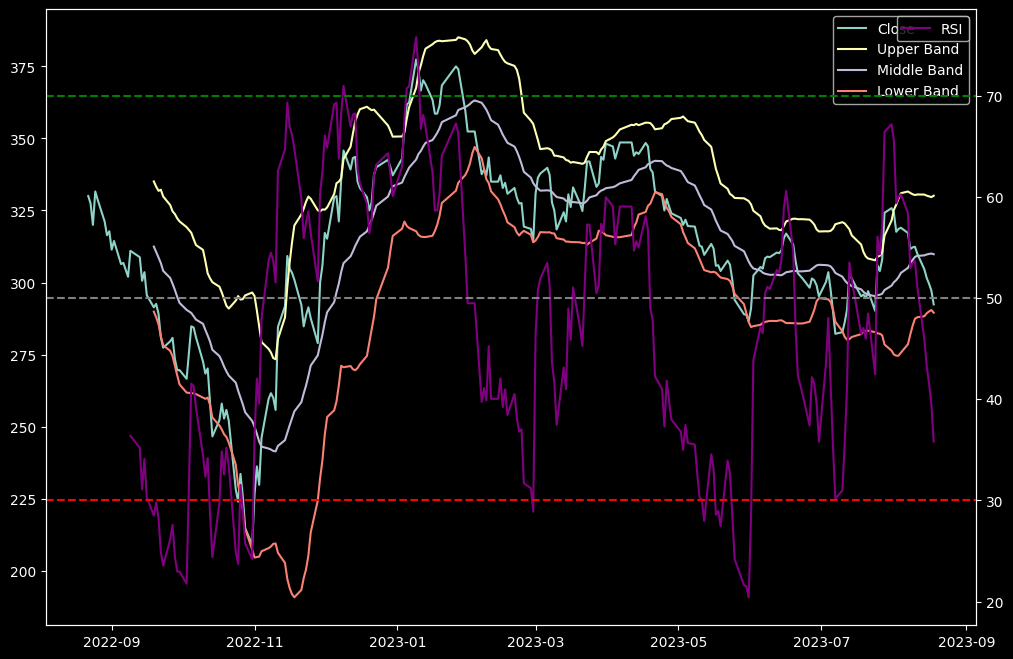

,Open,High,Low,Close,Adj Close,Volume,20ma,upper,lower,long,short,middle,rsi
Date,,,,,,,,,,,,,
2022-12-09,339.000000,349.000000,335.799988,345.799988,342.018127,8862820,306.710001,342.818832,270.601170,False,False,306.710001,70.989081
2023-01-05,360.000000,365.000000,359.200012,361.799988,357.843140,7675714,338.240001,356.834448,319.645554,False,True,338.240001,70.733460
2023-01-06,360.200012,366.000000,358.200012,362.399994,358.436584,6264530,339.860001,360.798420,318.921581,False,False,339.860001,70.951073
2023-01-09,370.000000,382.399994,367.000000,377.399994,373.272522,8422963,342.670000,367.550599,317.789401,False,True,342.670000,75.796313
2023-01-10,379.600006,381.000000,370.600006,373.799988,369.711914,5538044,344.579999,372.656147,316.503851,False,False,344.579999,72.663751


In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import talib
import time

# Download historical data of the stock
stock = df

# Calculate Bollinger Bands and RSI
stock['upper'], stock['middle'], stock['lower'] = talib.BBANDS(stock['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
stock['rsi'] = talib.RSI(stock['Close'], timeperiod=14)

# Plot the stock price, Bollinger Bands, and RSI
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(stock.index, stock['Close'], label='Close')
ax.plot(stock.index, stock['upper'], label='Upper Band')
ax.plot(stock.index, stock['middle'], label='Middle Band')
ax.plot(stock.index, stock['lower'], label='Lower Band')
ax.legend()
ax2 = ax.twinx()
ax2.plot(stock.index, stock['rsi'], color='purple', label='RSI')
ax2.axhline(y=30, color='red', linestyle='--')
ax2.axhline(y=50, color='gray', linestyle='--')
ax2.axhline(y=70, color='green', linestyle='--')
ax2.legend()

# Trading loop
position = 0
for i in range(20, len(stock)):
    # Buy signal: when the price crosses below the lower band and RSI is below 30
    if stock['Adj Close'][i] < stock['lower'][i] and position == 0 and stock['rsi'][i] < 30 :
        position = 1
        buy_price = stock['Adj Close'][i]
        print(f'Buy signal detected on {stock.index[i].strftime("%Y-%m-%d")} at {buy_price:.2f}.')

    # Sell signal: when the price crosses above the upper band and RSI is above 70
    if stock['Adj Close'][i] > stock['upper'][i] or position == 1 and stock['rsi'][i] > 70:
        position = 0
        sell_price = stock['Adj Close'][i]
        print(f'Sell signal detected on {stock.index[i].strftime("%Y-%m-%d")} at {sell_price:.2f}.')
        print(f'Profit/Loss: {(sell_price - buy_price) / buy_price * 100:.2f}%')
    # Close order: when RSI rises above 50 or falls below 50
    if (stock['rsi'][i] > 50 and position == 1) or (stock['rsi'][i] < 50 and position == -1):
        position = 0
        close_price = stock['Adj Close'][i]
        print(f'Order closed on {stock.index[i].strftime("%Y-%m-%d")} at {close_price:.2f}.')
        print(f'Profit/Loss: {(close_price - buy_price) / buy_price * 100:.2f}%')
    # Hold position
    else:
        pass

#time.sleep(0.1)  # To avoid hitting the API rate limit

# Plot the final position of the trade
if position == 1:
    ax.axvline(x=stock.index[-1], color='blue', linestyle='--')
elif position == -1:
    ax.axvline(x=stock.index[-1], color='red', linestyle='--')

plt.show()
re = stock[stock['rsi'] > 70]
re



In [ ]:
df2 = pd.DataFrame()
df2['K'],df2['D'] = talib.STOCH(df['High'], df['Low'], df['Adj Close'], 20,5,5)
print(df2['K'].isna().sum())
print(df2['D'].isna().sum())
print(df2)

25
25
                    K          D
Date                            
2022-08-22        NaN        NaN
2022-08-23        NaN        NaN
2022-08-24        NaN        NaN
2022-08-25        NaN        NaN
2022-08-26        NaN        NaN
...               ...        ...
2023-08-14  49.437008  53.488713
2023-08-15  44.624379  49.153288
2023-08-16  38.146648  44.069345
2023-08-17  31.713904  38.161644
2023-08-18  25.641029  31.833860

[245 rows x 2 columns]


In [ ]:
# TRIX strategy (Two Methods)
df2['TRIX'] = ta.trend.TRIXIndicator(df['Adj Close'], window=14).trix()

def TRIX(df, n):

  df["EMA1"] = talib.EMA(df["Adj Close"], 14)
  df["EMA2"] = talib.EMA(df["EMA1"], 14)
  df["EMA3"] = talib.EMA(df["EMA2"], 14)
  df["TEMA"] = (3*df["EMA1"])-(3*df["EMA2"])+df["EMA3"]
  i = 0
  ROC_l = [0]
  while i + 1 <= len(df)-1:
      ROC = (df["EMA3"][i + 1] - df["EMA3"][i]) / df["EMA3"][i]
      ROC_l.append(ROC)
      i = i + 1
  Trix = pd.Series(ROC_l, name = 'Trix_14')
  Trix = Trix.to_frame()
  df = df.join(Trix)

  return ROC_l
print(df2['TRIX'].isna().sum())

df["Trix"] = TRIX(df,14)
print((df["EMA3"][40]-df["EMA3"][39])/(df["EMA3"][40]))
df[40:]


40
-0.006245176549980106


,Open,High,Low,Close,Adj Close,Volume,20ma,upper,lower,long,short,middle,rsi,ATR,EMA1,EMA2,EMA3,Trix,TEMA
Date,,,,,,,,,,,,,,,,,,,
2022-10-19,258.000000,260.799988,252.600006,252.800003,250.035248,3718381,270.830000,294.317961,247.342040,False,False,270.830000,32.561320,9.484619,262.851006,275.488515,287.144769,-0.006206,249.232242
2022-10-20,252.199997,262.600006,246.600006,255.800003,253.002426,6766067,269.160000,291.924389,246.395611,False,False,269.160000,35.211783,9.950003,261.537862,273.628428,285.342590,-0.006276,249.070892
2022-10-21,257.600006,257.600006,251.000000,252.000000,249.243988,3533425,267.710000,290.962169,244.457830,False,False,267.710000,33.420074,9.710718,259.898679,271.797795,283.536617,-0.006329,247.839269
2022-10-24,248.600006,250.000000,225.600006,228.199997,225.704269,13620704,265.250000,293.708494,236.791506,True,False,265.250000,24.880792,10.902809,255.339424,269.603346,281.678848,-0.006552,238.887084
2022-10-25,228.199997,229.399994,221.000000,224.000000,221.550217,14376964,262.470000,295.304436,229.635563,True,False,262.470000,23.728555,10.724036,250.834197,267.100792,279.735107,-0.006901,230.935320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-14,305.200012,305.200012,302.200012,304.600006,304.600006,3477749,309.410004,330.517908,288.302100,False,False,309.410004,45.937432,8.043080,310.995912,308.539937,304.468316,0.002062,311.836242
2023-08-15,303.000000,306.600006,300.200012,301.600006,301.600006,2765712,309.730003,330.149319,289.310688,False,False,309.730003,43.298645,7.925717,309.743125,308.700362,305.032589,0.001853,308.160877
2023-08-16,299.200012,301.799988,297.000000,299.600006,299.600006,3524719,309.920004,329.882929,289.957080,False,False,309.920004,41.583685,7.702451,308.390709,308.659075,305.516120,0.001585,304.711022


In [ ]:
#ATR calculation

df['ATR'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'], window=14)
print(df['ATR'].isna().sum())
df[14:]

0


,Open,High,Low,Close,Adj Close,Volume,20ma,upper,lower,long,short,middle,rsi,ATR
Date,,,,,,,,,,,,,,
2022-09-09,303.000000,312.600006,302.000000,311.000000,307.598724,3437230,NaN,NaN,NaN,False,False,NaN,36.389682,7.668367
2022-09-13,309.200012,313.399994,308.000000,308.799988,305.422791,2062982,NaN,NaN,NaN,False,False,NaN,35.195045,7.506340
2022-09-14,300.799988,303.000000,298.000000,300.600006,297.312469,4176724,NaN,NaN,NaN,False,False,NaN,31.097234,7.741601
2022-09-15,299.200012,303.600006,299.200012,303.600006,300.279663,1959606,NaN,NaN,NaN,False,False,NaN,34.119418,7.502914
2022-09-16,299.200012,301.399994,295.200012,295.600006,292.367157,4967190,NaN,NaN,NaN,False,False,NaN,30.302475,7.566991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-14,305.200012,305.200012,302.200012,304.600006,304.600006,3477749,309.410004,330.517908,288.302100,False,False,309.410004,45.937432,8.043080
2023-08-15,303.000000,306.600006,300.200012,301.600006,301.600006,2765712,309.730003,330.149319,289.310688,False,False,309.730003,43.298645,7.925717
2023-08-16,299.200012,301.799988,297.000000,299.600006,299.600006,3524719,309.920004,329.882929,289.957080,False,False,309.920004,41.583685,7.702451


In [ ]:
import pandas as pd
import numpy as np
import talib

def stochastic_oscillator(df, n, m):
    """
    Function to calculate the Stochastic oscillator
    :param df: pandas.DataFrame containing the price data
    :param n: int, number of periods for %K calculation
    :param m: int, number of periods for %D calculation
    :return: pandas.DataFrame with %K and %D values
    """
    # Calculate the %K and %D values using talib functions
    df['%K'], df['%D'] = talib.STOCH(df['High'], df['Low'], df['Close'], fastk_period=n, slowk_period=m, slowd_period=m)

    return df


def relative_strength_index(df, n):
    """
    Function to calculate the Relative Strength Index (RSI)
    :param df: pandas.DataFrame containing the price data
    :param n: int, number of periods for RSI calculation
    :return: pandas.DataFrame with RSI values
    """
    # Calculate the RSI using talib function
    df['RSI'] = talib.RSI(df['Close'], timeperiod=n)

    return df


def get_signals(df):
    """
    Function to generate buy and sell signals based on Stochastic oscillator and RSI values
    :param df: pandas.DataFrame containing the price data with %K, %D, and RSI values
    :return: pandas.DataFrame with buy and sell signals
    """
    # Generate buy signal when %K crosses above %D and RSI is below 30
    df['Buy'] = np.where((df['%K'] > df['%D']) & (df['RSI'] < 30), 1, 0)

    # Generate sell signal when %K crosses below %D and RSI is above 70
    df['Sell'] = np.where((df['%K'] < df['%D']) & (df['RSI'] > 70), 1, 0)

    return df

# Example usage


stochastic_oscillator(df, n=14, m=3)
relative_strength_index(df, n=14)
get_signals(df)

# Check if Buy and Sell signals are generated correctly
for i in range(1,4):

  stoch = df[0:18+i]
  H = stoch["High"].max()
  L = stoch["Low"].min()
  C = (df["Adj Close"][19+i])
  print((C-L)/(H-L)*100)

-15.263286389802634
-6.703232514882494
-25.052439127114656


In [ ]:
import ta
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# Set starting capital and trade frequency
capital = 10000
trade_freq = 365

# Load historical stock price data

# Calculate ATR, MACD, and RSI
df['ATR'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'], window=14)
df['MACD'] = ta.trend.macd(df['Close'], window_slow=26, window_fast=12)
df['RSI'] = ta.momentum.rsi(df['Close'], window=14)

# Confirm trading signals
df['long'] = (df['MACD'] > df['MACD'].rolling(window=9).mean()) & (df['RSI'] < 30) & (df['ATR'] > df['Close'] * 0.02)
df['short'] = (df['MACD'] < df['MACD'].rolling(window=9).mean()) & (df['RSI'] > 70) & (df['ATR'] > df['Close'] * 0.02)

# Initialize trading variables
position = 0
trades = []
wins = 0
losses = 0
consecutive_wins = 0
consecutive_losses = 0

# Perform trades and calculate metrics
for i in range(len(df)):
    if df['long'][i]:
        if position == 0:
            position = 1
            trades.append(df['Close'][i])
            if len(trades) > trade_freq:
                if trades[-1] > trades[-trade_freq]:
                    consecutive_wins += 1
                    if consecutive_losses > 0:
                        consecutive_losses = 0
                else:
                    consecutive_losses += 1
                    if consecutive_wins > 0:
                        consecutive_wins = 0
        elif position == -1:
            position = 1
            trades.append(df['Close'][i])
            losses += 1
            if consecutive_losses > 0:
                consecutive_losses = 0
            consecutive_wins += 1
    elif df['short'][i]:
        if position == 0:
            position = -1
            trades.append(df['Close'][i])
            if len(trades) > trade_freq:
                if trades[-1] < trades[-trade_freq]:
                    consecutive_wins += 1
                    if consecutive_losses > 0:
                        consecutive_losses = 0
                else:
                    consecutive_losses += 1
                    if consecutive_wins > 0:
                        consecutive_wins = 0
        elif position == 1:
            position = -1
            trades.append(df['Close'][i])
            losses += 1
            if consecutive_wins > 0:
                consecutive_wins = 0
            consecutive_losses += 1
    else:
        if position == 1:
            position = 0
            trades.append(df['Close'][i])
            wins += 1
            if consecutive_losses > 0:
                consecutive_losses = 0
            if consecutive_wins > 0:
                consecutive_wins += 1
        elif position == -1:
            position = 0
            trades.append(df['Close'][i])
            wins += 1
            if consecutive_wins > 0:
                consecutive_wins = 0
            if consecutive_losses > 0:
                consecutive_losses += 1

# Calculate metrics
total_trades = wins + losses
win_rate = wins / total_trades
sharpe_ratio = np.sqrt(252) * (np.mean(trades) / np.std(trades))
volatility = np.std(trades)
max_consecutive_wins = consecutive_wins
max_consecutive_losses = consecutive_losses

# Print metrics
print(f"Win rate: {win_rate:.2%}")
print(f"Sharpe ratio: {sharpe_ratio:.2f}")
print(f"Volatility: {volatility:.2%}")
print(f"Maximum consecutive wins: {max_consecutive_wins}")
print(f"Maximum consecutive losses: {max_consecutive_losses}")



Win rate: 100.00%
Sharpe ratio: 679.38
Volatility: 590.00%
Maximum consecutive wins: 0
Maximum consecutive losses: 0


In [ ]:
# !pip install cufflinks
import cufflinks as cf
cf.go_offline()
import plotly as py
import ta
import yfinance as yf
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import *
init_notebook_mode(connected=False)

df = yf.download(tickers='0052.HK', start="2022-05-01", end="2023-06-05", interval="1d") #Download the data
df = pd.DataFrame(df)
qf=cf.QuantFig(df,title='First Quant Figure',legend='top',name='GS')
qf.add_bollinger_bands()
qf.add_sma([10,20],width=2,color=['green','lightgreen'],legendgroup=True)
qf.add_rsi(periods=20,color='java')
qf.add_bollinger_bands(periods=20,boll_std=2,colors=['magenta','grey'],fill=True)
qf.add_volume()
qf.add_macd()
qf.iplot()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("Cufflinks Version : {}".format(cf.__version__))

In [ ]:
cf.set_config_file(offline=True)

In [ ]:
import ta
import talib
import yfinance as yf

# 載入歷史股價資料
# c = df["Adj Close"].values
c = df["Adj Close"].values
# 計算 RSI 和 MACD
df['rsi'] = ta.momentum.RSIIndicator(df['Adj Close'], window=14).rsi()

# Calculate MACD and signal line
df["macd"], df["macd_signal"], df["macd_hist"] = talib.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
macd = np.array(df['macd'])
signal = np.array(df['macd_signal'])

# Create a new column for the MACD difference
df['macd_diff'] = macd - signal

# 計算 Bollinger Band
# EMA = 20 with average
df['20ma'] = ta.volatility.bollinger_mavg(df['Close'], window=20)
df['upper'] = ta.volatility.bollinger_hband(df['Close'], window=20)
df['lower'] = ta.volatility.bollinger_lband(df['Close'], window=20)

# 確認交易訊號
df['long'] = (df['rsi'] < 30) | (df['macd_diff'] > 0) & (df['Adj Close'] < df['lower'])
df['short'] = (df['rsi'] > 70) | (df['macd_diff'] < 0) & (df['Adj Close'] > df['upper'])

# 進行交易
position = 0
for i in range(len(df)):
    if df['long'][i]:
        if position == 0:
            position = 1
            print('Long：', df['Close'][i])
    elif df['short'][i]:
        if position == 1:
            position = 0
            print('Short：', df['Close'][i])

df.reset_index()
print(df['macd'].isna().sum())
df[32:]

Long： 14.039999961853027
Short： 10.880000114440918
Long： 11.720000267028809
33


,Open,High,Low,Close,Adj Close,Volume,rsi,macd,macd_signal,macd_hist,macd_diff,20ma,upper,lower,long,short
Date,,,,,,,,,,,,,,,,
2022-06-20,13.66,13.88,13.64,13.70,13.086683,22500,30.886784,NaN,NaN,NaN,NaN,13.995,14.355416,13.634583,False,False
2022-06-21,13.84,13.84,13.78,13.82,13.201310,16500,39.294863,-0.139534,-0.116727,-0.022807,-0.022807,13.981,14.345741,13.616259,False,False
2022-06-22,13.78,13.78,13.58,13.58,12.972055,31750,31.136218,-0.150780,-0.123537,-0.027243,-0.027243,13.958,14.360969,13.555031,False,False
2022-06-23,13.62,13.80,13.60,13.70,13.086683,14755,38.060955,-0.148729,-0.128576,-0.020153,-0.020153,13.944,14.362110,13.525890,False,False
2022-06-24,13.70,13.84,13.60,13.84,13.220415,25500,45.008585,-0.134759,-0.129812,-0.004946,-0.004946,13.941,14.361186,13.520814,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-29,11.90,11.90,11.40,11.52,11.520000,71000,32.040869,-0.022752,0.061712,-0.084464,-0.084464,12.185,12.742978,11.627022,False,False
2023-05-30,11.52,11.52,11.02,11.12,11.120000,44500,25.958412,-0.100143,0.029341,-0.129485,-0.129485,12.154,12.857375,11.450625,True,False
2023-05-31,11.12,11.20,10.86,11.00,11.000000,43000,24.458358,-0.169209,-0.010369,-0.158840,-0.158840,12.108,12.969199,11.246801,True,False


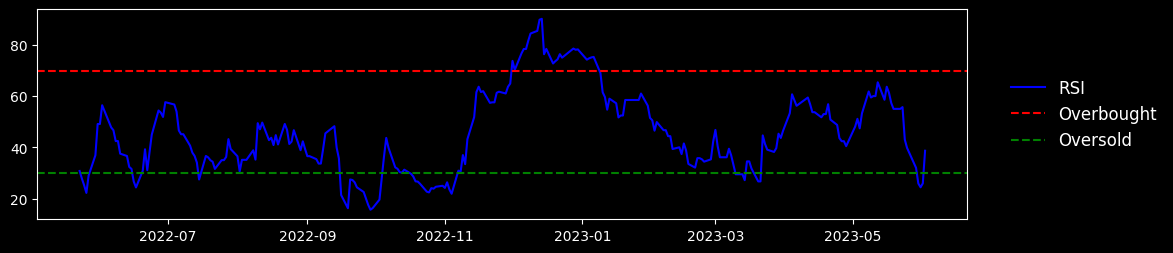

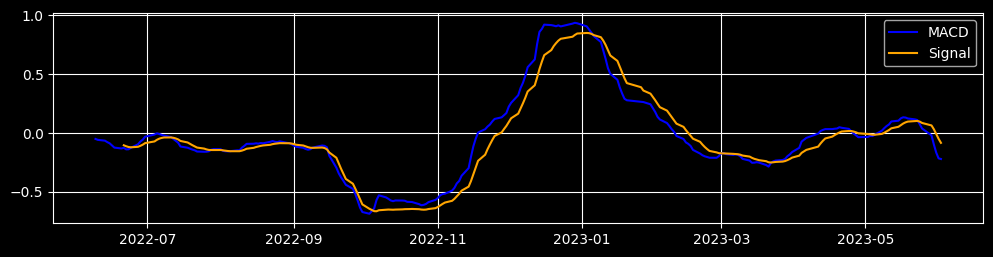

In [ ]:
# !pip install ta
import numpy as np
import ta
import yfinance as yf
import matplotlib.pyplot as plt


# Calculate RSI and MACD
df['rsi'] = ta.momentum.RSIIndicator(df['Adj Close'], window=14).rsi()
df['macd'] = ta.trend.MACD(df['Adj Close']).macd()
df['signals'] = ta.trend.MACD(df['Adj Close']).macd_signal()

macd = np.array(df['macd'])
signals = np.array(df['signals'])

# RSI plotting
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df.index, df['rsi'], label='RSI',color='b')
plt.axhline(y=70, color='red', linestyle='--', label='Overbought')
plt.axhline(y=30, color='green', linestyle='--', label='Oversold')

plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0,frameon=False,fontsize = 12)

# MACD plotting
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 2)
plt.plot(df.index, df['macd'], label='MACD',color='b')
plt.plot(df.index, ta.trend.MACD(df['Close']).macd_signal(), label='Signal',color='orange')
idx = np.argwhere(np.diff(np.sign(np.array(macd)- np.array(signals)))).flatten()
plt.plot(macd[idx[0]],signals[idx[0]], 'ko')
plt.legend()
plt.grid(True)

# Visulaize
plt.show()

In [ ]:
def intersection(lst_1,lst_2):
    intersections = []
    insights = []
    if len(lst_1) > len(lst_2):
        settle = len(lst_2)
    else:
        settle = len(lst_1)
    for i in range(settle-1):
        if (lst_1[i+1] < lst_2[i+1]) != (lst_1[i] < lst_2[i]):
            if ((lst_1[i+1] < lst_2[i+1]),(lst_1[i] < lst_2[i])) == (True,False):
                insights.append('buy')
            else:
                insights.append('sell')
            intersections.append(i)
    return intersections,insights
intersections,insights = intersection(df["signals"],df["macd"])

profit = 0
pat = 1
for i in range(len(intersections)-pat):
    index = intersections[i]
    true_trade= None
    if df['Adj Close'][index] < df['Adj Close'][index+pat]:
        true_trade = 'buy'
    elif df['Adj Close'][index] > df['Adj Close'][index+pat]:
        true_trade = 'sell'
    if true_trade != None:
        if insights[i] == true_trade:
            profit += abs(df['Adj Close'][index]-df['Adj Close'][index+1])
        if insights[i] != true_trade:
            profit += -abs(df['Adj Close'][index]-df['Adj Close'][index+1])

print(profit)
print(intersections)
print(insights)

df.iloc[(intersections)]


0.8059587478637695
[36, 46, 59, 61, 65, 80, 90, 92, 107, 109, 122, 167, 220, 240, 247, 260]
['buy', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy', 'sell']


,Open,High,Low,Close,Adj Close,Volume,rsi,macd,macd_signal,macd_hist,macd_diff,20ma,upper,lower,long,short,signals
Date,,,,,,,,,,,,,,,,,
2022-06-24,13.70,13.84,13.60,13.84,13.220415,25500,45.008585,-0.128217,-0.129812,-0.004946,-0.004946,13.941,14.361186,13.520814,False,False,-0.118710
2022-07-11,13.82,13.82,13.76,13.76,13.143997,25500,40.700098,-0.037320,-0.041808,0.003121,0.003121,13.883,14.227390,13.538610,True,False,-0.038566
2022-07-28,13.38,13.68,13.32,13.50,12.895637,34500,43.260882,-0.144381,-0.141500,-0.003096,-0.003096,13.636,14.206698,13.065302,False,False,-0.140969
2022-08-01,13.40,13.32,13.32,13.32,12.723695,1000,36.574732,-0.140264,-0.141003,0.000574,0.000574,13.555,14.020253,13.089747,True,False,-0.140601
2022-08-05,13.20,13.30,13.14,13.20,12.609067,29188,35.177723,-0.157299,-0.150654,-0.006747,-0.006747,13.402,13.730609,13.073390,False,False,-0.150419
2022-08-26,13.14,13.30,13.02,13.26,12.666381,40000,46.757495,-0.073525,-0.084983,0.011437,0.011437,13.257,13.441293,13.072707,True,False,-0.084945
2022-09-09,12.90,13.10,12.88,13.02,12.437125,64000,45.511623,-0.126379,-0.123141,-0.003247,-0.003247,13.086,13.438613,12.733387,False,False,-0.123126
2022-09-14,12.88,12.88,12.46,12.46,12.277658,81500,39.960155,-0.111940,-0.118686,0.006739,0.006739,13.036,13.459245,12.612755,True,False,-0.118674
2022-10-06,10.70,11.00,10.70,10.98,10.819317,17000,43.742762,-0.572599,-0.563474,-0.009126,-0.009126,11.325,13.421736,9.228264,False,False,-0.563471


In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import talib

# 定義交易策略
def algo_trading(stock, initial_capital, num_simulations, num_days):
    # 載入歷史股價資料
    df = yf.download(tickers='0005.HK', start="2022-04-01", end="2023-05-31", interval="1d")

    # 計算每日收益率
    daily_returns = df['Close'].pct_change()

    # 計算每日平均收益率和標準差
    mean_daily_returns = daily_returns.mean()
    std_daily_returns = daily_returns.std()

    # 計算模擬交易結果
    results = []
    for i in range(num_simulations):
        # 初始化參數
        capital = initial_capital
        prices = [df['Adj Close'][-1]]

        # 模擬交易
        for j in range(num_days):
            # 計算技術指標
            rsi = talib.RSI(df['Adj Close'], timeperiod=14)[-1]
            macd, macdsignal, macdhist = talib.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
            if macd[-1] > macdsignal[-1] and macd[-2] < macdsignal[-2] and rsi < 30:
                price = prices[-1] * (1 + np.random.normal(mean_daily_returns, std_daily_returns))
                capital *= 1.01
            elif macd[-1] < macdsignal[-1] and macd[-2] > macdsignal[-2] and rsi > 70:
                price = prices[-1] * (1 + np.random.normal(mean_daily_returns, std_daily_returns))
                capital *= 0.99
            else:
                price = prices[-1] * (1 + np.random.normal(mean_daily_returns, std_daily_returns))

            prices.append(price)

        # 紀錄最終資本額
        results.append(capital)

    # 繪製結果圖表
    plt.hist(results, bins=253)
    plt.axvline(x=np.percentile(results, 5), color='r', linestyle='-')
    plt.axvline(x=np.percentile(results, 95), color='b', linestyle='-')
    plt.xlabel('Capital')
    plt.ylabel('Frequency')
    plt.show()

# 執行交易策略
stock = yf.Ticker('0916.HK')
algo_trading(stock, 10000, 1000, 252)


[*********************100%%**********************]  1 of 1 completed


KeyboardInterrupt: ignored

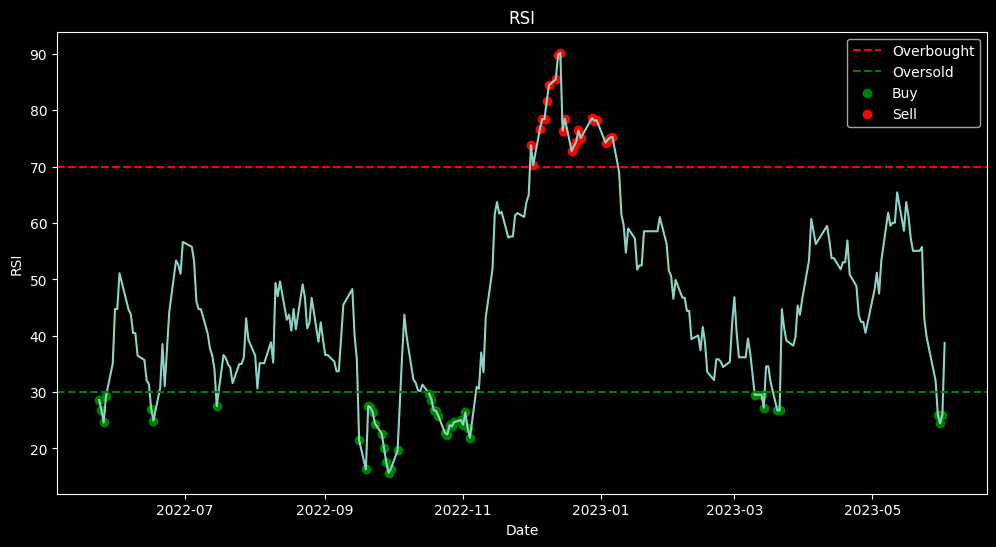

In [ ]:
import yfinance as yf
import talib

# 載入歷史股價資料

# 計算 RSI 技術指標
rsi = talib.RSI(df['Adj Close'], timeperiod=14)

# 列印所有 RSI 值
for i in range(len(rsi)):
    (f"RSI ({i}): {rsi[i]}")

plt.figure(figsize=(12, 6))
plt.plot(rsi)
plt.axhline(y=70, color='red', linestyle='--', label='Overbought')
plt.axhline(y=30, color='green', linestyle='--', label='Oversold')
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('RSI')

buy_signal = rsi < 30
sell_signal = rsi > 70
plt.scatter(df.index[buy_signal], rsi[buy_signal], color='green', label='Buy')
plt.scatter(df.index[sell_signal], rsi[sell_signal], color='red', label='Sell')
plt.legend()

plt.show()

In [ ]:
import talib
c = df["Adj Close"].values
fast_ema = talib.EMA(c, 12)
slow_ema = talib.EMA(c, 26)
macd_diff = fast_ema - slow_ema
fast_ema = pd.DataFrame(fast_ema)
slow_ema = pd.DataFrame(slow_ema)
macd_diff = pd.DataFrame(macd_diff)
data = pd.concat([fast_ema, slow_ema,macd_diff], axis="columns")
data = data[25:].reset_index()
data.columns = ["Days","Fast","Slow","MACD"]
data = data.drop(columns=["Days"])
data

,Fast,Slow,MACD
0,13.504640,13.556216,-0.051577
1,13.481487,13.541248,-0.059761
2,13.458957,13.525974,-0.067017
3,13.425198,13.504755,-0.079557
4,13.393693,13.483693,-0.090000
...,...,...,...
238,12.111281,12.134033,-0.022752
239,11.958776,12.058919,-0.100143
240,11.811272,11.980481,-0.169209
241,11.692615,11.910816,-0.218201


Win rate: 39.54%
Sharpe ratio: -2.39
Volatility: 28.02%
Return percentage: -48.40%
Number of trading days:  268
Number of win days:  102
Number of lose days:  139
Maximum consecutive winning days:  6
Maximum consecutive losing days:  7


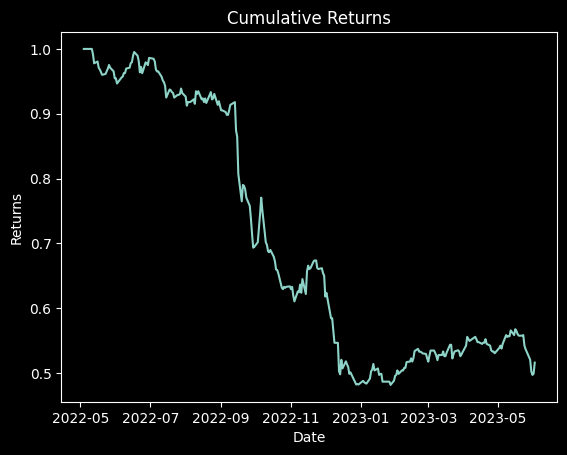

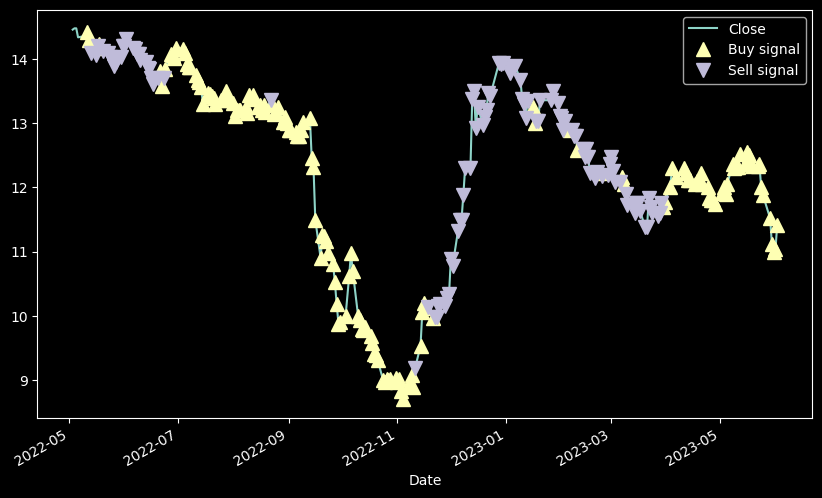

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# Get historical stock data for a ticker symbol
data = df

# Calculate the high and low points for the chart patterns
highs = data["High"]
lows = data["Low"]

# Identify where the chart patterns occur
data["Signal"] = 0

# Identify pennant pattern
for i in range(2, len(data)-2):
    if highs[i] > highs[i-1] and lows[i] > lows[i-1] and highs[i] < highs[i-2] and lows[i] > lows[i-2]:
        data["Signal"][i] = 1
    elif highs[i] < highs[i-1] and lows[i] < lows[i-1] and highs[i] > highs[i-2] and lows[i] < lows[i-2]:
        data["Signal"][i] = -1

# Identify flag pattern
for i in range(2, len(data)-2):
    if highs[i-1] < highs[i-2] and lows[i-1] < lows[i-2] and highs[i] > highs[i-2] and lows[i] > lows[i-2]:
        data["Signal"][i] = 1
    elif highs[i-1] > highs[i-2] and lows[i-1] > lows[i-2] and highs[i] < highs[i-2] and lows[i] < lows[i-2]:
        data["Signal"][i] = -1

# Identify triangle pattern
for i in range(2, len(data)-2):
    if lows[i] > lows[i-1] and highs[i] < highs[i-1] and lows[i-1] < lows[i-2] and highs[i-1] > highs[i-2]:
        data["Signal"][i] = 1
    elif lows[i] < lows[i-1] and highs[i] > highs[i-1] and lows[i-1] > lows[i-2] and highs[i-1] < highs[i-2]:
        data["Signal"][i] = -1


# Identify head and shoulders pattern
for i in range(3, len(data)-3):
    if highs[i-1] > highs[i-2] and highs[i-1] > highs[i] and lows[i-1] > lows[i-2] and lows[i-1] > lows[i]:
        if highs[i+1] < highs[i+2]:
            data["Signal"][i+1:i+3] = -1
        else:
            data["Signal"][i+1:] = -1
    elif highs[i-1] < highs[i-2] and highs[i-1] < highs[i] and lows[i-1] < lows[i-2] and lows[i-1] < lows[i]:
        if highs[i+1] > highs[i+2]:
            data["Signal"][i+1:i+3] = 1
        else:
            data["Signal"][i+1:] = 1

# Calculate the returns
data["Returns"] = np.log(data["Close"] / data["Close"].shift(1))

# Calculate the strategy returns
data["Strategy"] = data["Signal"].shift(1) * data["Returns"]

# Calculate the cumulative returns
data["Cumulative Returns"] = np.exp(data["Strategy"].cumsum())

# Calculate the win rate
win_rate = len(data[data["Strategy"] > 0]) / len(data[data["Signal"] != 0])
print("Win rate: {:.2%}".format(win_rate))

# Calculate the Sharpe ratio
sharpe_ratio = np.sqrt(len(data)) * data["Strategy"].mean() / data["Strategy"].std()
print("Sharpe ratio: {:.2f}".format(sharpe_ratio))

# Calculate the volatility
volatility = np.sqrt(len(data)) * data["Returns"].std()
print("Volatility: {:.2%}".format(volatility))

# Calculate the return percentage
return_percentage = (data["Cumulative Returns"][-1] - 1) * 100
print("Return percentage: {:.2f}%".format(return_percentage))

# Calculate the number of trading days, win days, and lose days
num_trading_days = len(data)
num_win_days = len(data[data["Returns"] > 0])
num_lose_days = len(data[data["Returns"] < 0])
print("Number of trading days: ", num_trading_days)
print("Number of win days: ", num_win_days)
print("Number of lose days: ", num_lose_days)

# Calculate the maximum number of consecutive winning days
max_win_streak = 0
win_streak = 0
for i in range(len(data)):
    if data.loc[data.index[i], "Strategy"] > 0:
        win_streak += 1
        max_win_streak = max(max_win_streak, win_streak)
    else:
        win_streak = 0

# Calculate the maximum number of consecutive losing days
max_lose_streak = 0
lose_streak = 0
for i in range(len(data)):
    if data.loc[data.index[i], "Strategy"] < 0:
        lose_streak += 1
        max_lose_streak = max(max_lose_streak, lose_streak)
    else:
        lose_streak = 0

print("Maximum consecutive winning days: ", max_win_streak)
print("Maximum consecutive losing days: ", max_lose_streak)

# Plot the results
plt.plot(data["Cumulative Returns"])
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

# Plot the results
data["Close"].plot(figsize=(10, 6))
data[data["Signal"] == 1]["Close"].plot(style="^", markersize=10, label="Buy signal")
data[data["Signal"] == -1]["Close"].plot(style="v", markersize=10, label="Sell signal")
plt.legend()
plt.show()


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the trading strategy
def trading_strategy(data, capital):
    # Calculate the volatility of the asset
    data = df
    data["log_returns"] = np.log(data["Close"]) - np.log(data["Close"].shift(1))
    data["volatility"] = data["log_returns"].rolling(window=14).std() * np.sqrt(252)

    # Simulate the trades using a martingale betting strategy with volatility adjustment
    trades = []
    position = 0
    win_days = 0
    lose_days = 0
    max_consecutive_wins = 0
    max_consecutive_losses = 0
    consecutive_wins = 0
    consecutive_losses = 0
    for i in range(1, len(data)):
        if data["Close"][i] < data["Close"][i-1] - data["volatility"][i]:
            if position == 0:
                position = capital / data["Close"][i]
                trades.append(-1)
                lose_days += 1
                consecutive_wins = 0
                consecutive_losses += 1
                if consecutive_losses > max_consecutive_losses:
                    max_consecutive_losses = consecutive_losses
            else:
                position = position * 2
                trades.append(-1)
                lose_days += 1
                consecutive_wins = 0
                consecutive_losses += 1
                if consecutive_losses > max_consecutive_losses:
                    max_consecutive_losses = consecutive_losses
        elif data["Close"][i] > data["Close"][i-1] + data["volatility"][i]:
            if position == 0:
                position = capital / data["Close"][i]
                trades.append(1)
                win_days += 1
                consecutive_wins += 1
                if consecutive_wins > max_consecutive_wins:
                    max_consecutive_wins = consecutive_wins
            else:
                position = position * 2
                trades.append(1)
                win_days += 1
                consecutive_wins += 1
                if consecutive_wins > max_consecutive_wins:
                    max_consecutive_wins = consecutive_wins
        else:
            trades.append(0)

    # Calculate the performance metrics for the simulated trades
    returns = np.array(trades) * np.array(data["log_returns"][1:])
    total_returns = np.cumsum(returns)[-1]
    win_rate = win_days / (win_days + lose_days)
    total_win_days = win_days
    total_lose_days = lose_days
    max_drawdown = np.max(np.maximum.accumulate(np.cumsum(returns)) - np.cumsum(returns))

    # Return the performance metrics
    return {
        "total_returns": total_returns,
        "win_rate": win_rate,
        "total_win_days": total_win_days,
        "total_lose_days": total_lose_days,
        "max_drawdown": max_drawdown,
        "max_consecutive_wins": max_consecutive_wins,
        "max_consecutive_losses": max_consecutive_losses
    }

trading_strategy(df,10000)

{'total_returns': 1.5172844115356257,
 'win_rate': 0.5172413793103449,
 'total_win_days': 30,
 'total_lose_days': 28,
 'max_drawdown': 0.0,
 'max_consecutive_wins': 8,
 'max_consecutive_losses': 28}

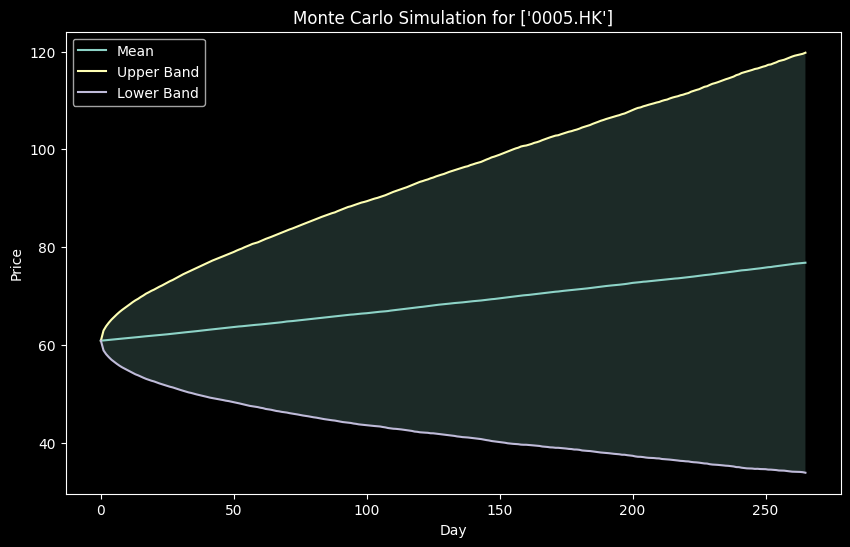

Win rate: 76.28%
Sharpe ratio: 0.84
Total trading days: 266
Profit/loss percentage: 26.21%
Volatility: 21.48%
Number of winning simulations: 7628
Number of losing simulations: 2372
Maximum consecutive winning days: 7
Maximum consecutive losing days: 37


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np


# Get historical stock data for a ticker symbol
data = df

# Define parameters for the simulation
num_simulations = 10000
num_days = len(data)

# Calculate daily returns
returns = data["Adj Close"].pct_change()
mean_daily_return = returns.mean()
std_dev_daily_return = returns.std()

# Run Monte Carlo simulation
simulation_results = np.zeros((num_days, num_simulations))
for i in range(num_simulations):
    daily_returns = np.random.normal(mean_daily_return, std_dev_daily_return, num_days)
    price_series = np.zeros(num_days)
    price_series[0] = data["Adj Close"][-1]
    for j in range(1, num_days):
        price_series[j] = price_series[j-1] * (1 + daily_returns[j])
    simulation_results[:, i] = price_series

# Calculate statistics of the simulation results
mean_simulated_price_series = np.mean(simulation_results, axis=1)
std_dev_simulated_price_series = np.std(simulation_results, axis=1)
upper_band = mean_simulated_price_series + 2 * std_dev_simulated_price_series
lower_band = mean_simulated_price_series - 2 * std_dev_simulated_price_series

# Plot the simulation results
plt.figure(figsize=(10, 6))
plt.plot(mean_simulated_price_series, label="Mean")
plt.plot(upper_band, label="Upper Band")
plt.plot(lower_band, label="Lower Band")
plt.fill_between(range(num_days), upper_band, lower_band, alpha=0.2)
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("Monte Carlo Simulation for {}".format(stocks))
plt.legend()
plt.show()

win_rate = (simulation_results[-1, :] > data["Adj Close"][-1]).mean()
sharpe_ratio = mean_daily_return / std_dev_daily_return * np.sqrt(num_days)
total_trading_days = len(data)
profit_loss_percentage = (mean_simulated_price_series[-1] - data["Adj Close"][-1]) / data["Adj Close"][-1] * 100
volatility = std_dev_simulated_price_series[-1]
num_winning_days = (simulation_results[-1, :] > data["Adj Close"][-1]).sum()
num_losing_days = (simulation_results[-1, :] < data["Adj Close"][-1]).sum()
max_consecutive_winning_days = np.max(np.diff(np.where(np.concatenate(([False], simulation_results[-1, :] > data["Adj Close"][-1], [False])))[0])[::2])
max_consecutive_losing_days = np.max(np.diff(np.where(np.concatenate(([False], simulation_results[-1, :] < data["Adj Close"][-1], [False])))[0])[::2])

# Print the metrics
print("Win rate: {:.2%}".format(win_rate))
print("Sharpe ratio: {:.2f}".format(sharpe_ratio))
print("Total trading days: {}".format(total_trading_days))
print("Profit/loss percentage: {:.2f}%".format(profit_loss_percentage))
print("Volatility: {:.2f}%".format(volatility))
print("Number of winning simulations: {}".format(num_winning_days))
print("Number of losing simulations: {}".format(num_losing_days))
print("Maximum consecutive winning days: {}".format(max_consecutive_winning_days))
print("Maximum consecutive losing days: {}".format(max_consecutive_losing_days))

In [ ]:
print("Total table for {}".format(stocks))
df["ATR"]